# BLEU SCORE
Rélexion basée sur {B}leu: a Method for Automatic Evaluation of Machine Translation", de Papineni, Kishore and Roukos, Salim and Ward, Todd and Zhu, Wei-Jing. (références en fin de document)

## Lecture supplémentaire
- Review + réceente de l'article : https://aclanthology.org/J18-3002.pdf
- Librairies python utilisées : nltk et evaluate (https://huggingface.co/spaces/evaluate-metric/bleu)
- Quelques infos sur colab : https://www.jcchouinard.com/google-colab-with-python/
- Quelques infos sur markdown : https://learninglab.gitlabpages.inria.fr/mooc-rr/mooc-rr-ressources/module1/ressources/introduction_to_markdown_fr.html

# Etude

Pour aider l'humain dans sa compréhension nous voulons :

1. Une métrique pour mesurer comment nue traduction se rapproche de la réalité
2. Un corpus de références de traduction de bonne qualité

Nous utilisons la mesure `BLEU` et la mesure `sacrebleu` et les libraries python NLTK et evaluate



In [ ]:
!pip install evaluate
!pip install sacrebleu
!pip install meteor

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, modified_precision
from nltk.util import ngrams
from collections import Counter
from fractions import Fraction
import evaluate
import math
import nltk

def count_clipped_ngrams(reference, hypothesis, n):
  # source : chatGPT
    ngrams_ref = Counter(ngrams(reference, n))
    ngrams_hyp = Counter(ngrams(hypothesis, n))

    count_ngram_hyp = sum(ngrams_hyp.values())

    count_ngram_match = sum(min(count, ngrams_ref[ngram]) for ngram, count in ngrams_hyp.items())

    precision = Fraction(count_ngram_match, count_ngram_hyp)

    return precision

def display_count(reference, hypothesis):
  for i in range(1, len(hypothesis)+1):
    total_ngrams = len(hypothesis) - i + 1

    # count clipped ngrams
    clipped_processing = modified_precision(references, hypothesis, i)
    clipped_precision = clipped_processing.numerator

    # display
    print("Comptage de "+str(i)+"-gram clippés :", str(clipped_precision) + "/" + str(total_ngrams), " ("+str(clipped_precision/total_ngrams)+")")


# Baseline : La métrique BLEU

La première tâche est de comparer les n-grammes de la référence avec les n-grammes de l'hypothèse et compter les correspondances (indépendament de la position)



## Précision

La pierre angulaire de la métrique est le concept de précision : Compter les nombre de token (unigrammes) présent dans la référence et diviser par le nombre de token de l'hypothèse. Lorsqu'un mot appartient à l'hypothèse et à la référence nous voulons qu'il soit aparié (mis à part) pour éviter qu'il soit compter deux fois. Cela introduit le concept de *précision d'unigramme modifiée*  (modified unigram precision). Intuitivement le nombre total d'occurrences de chaque mot candidat est limitée (clip en anglais) et comparée avec le nombre maximum d'occurrences de ce mot dans les références.

On additionne ensuite ces occurrences "clipées" et on divise le total par le nombre total de mots candidats (non "clippés"). Ce qui donne la formule suivante :

$p_n = \frac{\sum_{C \in \{Candidates \} } \sum_{n-gram \in C} \text{Count}_{\text{clip}}(\text{n-gram})}{\sum_{C' \in \{Candidates \} } \sum_{n-gram' \in C'} \text{Count}(\text{n-gram'})}$

C'est à dire que le nombre de n-grammes "clipés" pour chaque hypothèse est divisée par le nombre de n-grammes pour chaque hypothèses.

## Référence

Nous n'utilisons qu'une seule référence qui est une traduction en langue des signes de la phrase :

(...)Qui s'offraient aux bras dorés du soleil, Lui qui inondait le pays de ses étincelles,(...) provenant d'une chanson de l'artiste *Shuriken* appellée "les tam-tams de l'Afrique" et traduite en langue des signes (LSF)

REFERENCE : AFRIQUE OFFRIR BRAS DORE SOLEIL PAYS ETINCELLES

*NB: le cas avec plusieurs référence est laissé en exercice*


In [ ]:
reference = str('AFRIQUE OFFRIR BRAS DORE SOLEIL PAYS ETINCELLES').split()

references = [
    reference
]

print("référence : ",reference)

référence :  ['AFRIQUE', 'OFFRIR', 'BRAS', 'DORE', 'SOLEIL', 'PAYS', 'ETINCELLES']


## Hypothèse

Avec une seule hypothèse $p_n$ est donc calculée comme suit :

$p_n = \frac{\sum_{n-gram \in C} \text{Count}_{\text{clip}}(\text{n-gram})}{\sum_{n-gram' \in C'} \text{Count}(\text{n-gram'})}$ où C est l'hypothèse


# Traductions

Utilisons hugging faces pour effectuer les 3 traductions

In [ ]:
references = [
  ["AFRIQUE OFFRIR BRAS DORE SOLEIL PAYS ETINCELLES"]
]


prediction01 = ["AFRIQUE OFFRIR BRAS DORE ETOILE PAYS ETINCELLES"]
prediction02 = ["AFRIQUE OFFRIR BRAS"]
prediction03 = ["AFRIQUE OFFRIR BRAS DORE"]

sacrebleu = evaluate.load("sacrebleu")

results = sacrebleu.compute(references=references, predictions=prediction01)
print("score sacrebleu prediction 1 : ",results)

results = sacrebleu.compute(references=references, predictions=prediction02)
print("score sacrebleu prediction 2 : ",results)

results = sacrebleu.compute(references=references, predictions=prediction03)
print("score sacrebleu prediction 3 : ",results)

score sacrebleu prediction 1 :  {'score': 48.892302243490086, 'counts': [6, 4, 2, 1], 'totals': [7, 6, 5, 4], 'precisions': [85.71428571428571, 66.66666666666667, 40.0, 25.0], 'bp': 1.0, 'sys_len': 7, 'ref_len': 7}
score sacrebleu prediction 2 :  {'score': 0.0, 'counts': [3, 2, 1, 0], 'totals': [3, 2, 1, 0], 'precisions': [100.0, 100.0, 100.0, 0.0], 'bp': 0.2635971381157267, 'sys_len': 3, 'ref_len': 7}
score sacrebleu prediction 3 :  {'score': 47.23665527410149, 'counts': [4, 3, 2, 1], 'totals': [4, 3, 2, 1], 'precisions': [100.0, 100.0, 100.0, 100.0], 'bp': 0.4723665527410147, 'sys_len': 4, 'ref_len': 7}


In [ ]:
hypothesis = str('AFRIQUE OFFRIR BRAS DORE ETOILE PAYS ETINCELLES').split()
print("hypothèse : ",hypothesis)

hypothèse :  ['AFRIQUE', 'OFFRIR', 'BRAS', 'DORE', 'ETOILE', 'PAYS', 'ETINCELLES']


# Fonctionnement

Détaillons le fonctionnement de cette mesure


- La fonction Count_{clip}() renvoie le nombre de i-gramme d'ordre i de l'hypothèse qui existent dans la référence divisée par le nombre total de token de l'hypothèse. Nous sommons pour chaque ordre de i-gramme où $i \in [1, ..., n]$ et $n$ représente le nombre de token de l'hypothèse.

- La fonction Count() fonctionne selon le même principe mais sans "clipper" la phrase (comme expliqué au point précédent)

## Comptage

Les fonctions $Count_{clip}(n-gram)$ et $Count(n-gram)$ permettent de calculer la précision $p_n$. Affichons également le score BLEU en utilisant la fonction *sentence_bleu()* de la library nltk

In [ ]:
display_count(reference, hypothesis)

# nltk
# print('BLEU score -> {}'.format(sentence_bleu(references, hypothesis)))

op1 = ((6/7)**(1/4))
print("op1 : ",op1)

res = ((6/7)**(1/4)) * ((4/6)**(1/4)) * ((2/5)**(1/4)) * ((1/4)**(1/4))
res2 = ((6/7) * (4/6) * (2/5) * (1/4))**(1/4)
res3 = (2/35)**(1/4)

print("res = ",res3)

res_7gram = ((6/7)**(1/7)) * ((4/6)**(1/7)) * ((2/5)**(1/7)) * ((1/4)**(1/7)) * 0**(1/7) * 0**(1/7) * 0**(1/7)

print("BLEU 7gram = ",res_7gram)

Comptage de 1-gram clippés : 6/7  (0.8571428571428571)
Comptage de 2-gram clippés : 4/6  (0.6666666666666666)
Comptage de 3-gram clippés : 2/5  (0.4)
Comptage de 4-gram clippés : 1/4  (0.25)
Comptage de 5-gram clippés : 0/3  (0.0)
Comptage de 6-gram clippés : 0/2  (0.0)
Comptage de 7-gram clippés : 0/1  (0.0)
op1 :  0.9621954581957615
res =  0.48892302243490104
BLEU 7gram =  0.0


In [ ]:
import evaluate
import math

references_hf = [
  ["AFRIQUE OFFRIR BRAS DORE SOLEIL PAYS ETINCELLES"]
]

predictions_hf = ["AFRIQUE OFFRIR BRAS"]

# bleu = evaluate.load("bleu")
# results = bleu.compute(references=references_hf, predictions=predictions_hf)
# print("score BLEU : ",results)

sacrebleu = evaluate.load("sacrebleu")
results = sacrebleu.compute(references=references_hf, predictions=predictions_hf)
print("score sacrebleu : ",results)

# print("BP BLEU : {:.5f}".format(results["bp"]))

# print('BLEU nltk score -> {}'.format(sentence_bleu(references, predictions_hf)))

verif = math.exp( 1 - 7/3)
print("verif : ",verif)

verif2 = math.exp(-4/3)
print("verif2 : ",verif2)

verif3 = math.exp(-4)
print("verif3 : ",verif3)

verif4 = verif3 ** (1/3)
print("verif4 : ",verif4)

score sacrebleu :  {'score': 0.0, 'counts': [3, 2, 1, 0], 'totals': [3, 2, 1, 0], 'precisions': [100.0, 100.0, 100.0, 0.0], 'bp': 0.2635971381157267, 'sys_len': 3, 'ref_len': 7}
verif :  0.2635971381157267
verif2 :  0.26359713811572677
verif3 :  0.01831563888873418
verif4 :  0.26359713811572677


Vérifions les scores des n-grammes pour un cas qui se produit en NLP dans lequel le premier mot est répété plusieurs fois.

In [ ]:
hypothesis2 = str('AFRIQUE AFRIQUE AFRIQUE AFRIQUE AFRIQUE').split()
print("hypothèse : ", hypothesis2)

display_count(reference, hypothesis2)

print('BLEU score -> {}'.format(sentence_bleu(references, hypothesis2)))

hypothèse :  ['AFRIQUE', 'AFRIQUE', 'AFRIQUE', 'AFRIQUE', 'AFRIQUE']
Comptage de 1-gram clippés : 1/5  (0.2)
Comptage de 2-gram clippés : 0/4  (0.0)
Comptage de 3-gram clippés : 0/3  (0.0)
Comptage de 4-gram clippés : 0/2  (0.0)
Comptage de 5-gram clippés : 0/1  (0.0)
BLEU score -> 8.166726842395623e-232


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

### Calcul de la moyenne : Définition

Faisons apparaître une moyenne dans les comptages de n-grammes.

Avec $C$, une hypothèse et $k$ chaque n-gramme appartenant à $C$, nous avons :

$p_k = \frac{\text{Count}_{\text{clip}}(k)}{\text{Count}(k)}$, où $p_k$ est la mesure de précision d'un n-gramme spécifique (par exemple, les unigrammes ou les bigrammes de l'hypothèse présentes dans la référence).

Posons BLEU, une moyenne géométrique :

La fonction $count_{clip}$ compte ici le nombre de k-gramme de l'hypothèse
présentes dans la référence de manières clippées c'est à dire en ne comp-
tant pas deux fois la même glose et la fonction count le nombre de gloses
de l'hypothèse.

#### Moyenne géométrique.
Posons, $\mu$, une moyenne géométrique.

$\mu = \sqrt[n]{p_1 \times p_2 \times ... \times p_N}$, où $N$ est le nombre total de tokens dans l'hypothèse et $p_1, p_2, ..., p_N$ représentent les précisions modifiées pour chaque ordre de n-gramme.

$\mu = (p_1 \times p_2 \times ... \times p_N)^{\frac{1}{N}}$ (réécriture de la racine n-ième).

$\mu = \prod_{i=1}^N p_i^{\frac{1}{N}}$ (réécriture du produit).

Les auteur·e·s utilisent les propriétés du logarithme et la linéarité
de la somme pour parler de son domaine logarithmique dans l'article :

$log(\mu) = \frac{1}{N} \sum_{i=1}^N \log p_i$ (puisque $\log(a^b) = b \times \log(a)$) et que la somme est linéaire.

Utilisons la réciprocité des fonctions logarithme et exponentielle en com-
posant à droite avec l'exponentielle ce qui simplifie le logarithme à gauche :

$\mu = \exp\left(\frac{1}{N} \sum_{i=1}^N \log p_i\right)$.

Nous appliquons un poid $w$ pour chaque ordre de n-gramme. Un poid
uniforme est 1 de telle sortie que le coefficient de la somme est simplifiée :
N

$\tau = \exp\left(\frac{1}{N} \sum_{i=1}^N w_i \log p_i\right)$.



## Pénalité de consision

Les hypothèses plus longues que la référence sont déjà pénalisées puisque le nombre de token définit le dénominateur comme expliqué dans la section comptage. Une hypothèse plus courte que la référence pourrait obtenir un score trop élevé, la pénalité de consision (BP pour Brevety penality) pénalise les traductions trop courtes, elle est donnée par la formule suivante :

BP = \begin{cases}
1, & \text{if } c > r \\
e^{(1 - r/c)}, & \text{otherwise}
\end{cases}

où
- \(c\) représente le nombre de token de l'hypothèse
- \(r\) représente le nombre de token de la référence


<ipython-input-5-6f04d95ded34>:9: RuntimeWarning: divide by zero encountered in true_divide
  y = np.exp(1 - r/c)


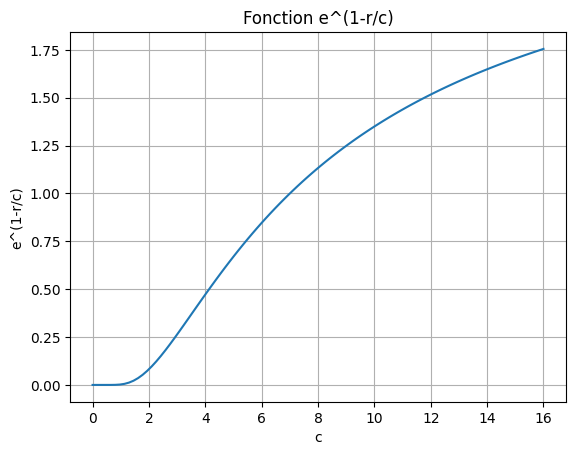

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
r = 7  # Valeur constante de r
c =  np.linspace(0, 16, 100)  # Valeurs de c allant de 0 à 16

# Calcul de la fonction
y = np.exp(1 - r/c)

# Tracé de la fonction
plt.plot(c, y)
plt.xlabel('c')
plt.ylabel('e^(1-r/c)')
plt.title('Fonction e^(1-r/c)')
plt.grid(True)
plt.show()

## Formule BLEU complète

La formule générale pour calculer le score BLEU est donnée par :

$\text{BLEU} = \text{BP} \times \exp\left(\sum_{n=1}^{N} w_n \log p_n\right)$

- La moyenne à gauche de l'équation a disparu car elle est prise en compte dans la fonction BP
- BP représente la pénalité de longueur (Brevity Penalty) qui ajuste le score BLEU en fonction des différences de longueur entre les traductions automatiques et les références.
- $w_n$ est le poids attribué à chaque n-gramme dans le calcul du score BLEU. Par défaut, tous les n-grammes ont le même poids et sont souvent définis à 1/N, où N est le nombre de n-grammes.
- N est l'ordre maximal des n-grammes considérés dans le calcul du score BLEU.
- $p_n$ est la précision des n-grammes, calculée à l'aide de la formule de précision que nous avons discutée précédemment.

## Calcul BLEU avec hugging face



In [ ]:
!pip install evaluate
!pip install sacrebleu

import evaluate

references_hf = [
  ["AFRIQUE OFFRIR BRAS DORE SOLEIL PAYS ETINCELLES"]
]

predictions_hf = ["AFRIQUE OFFRIR BRAS DORE ETOILE PAYS ETINCELLES"]

bleu = evaluate.load("bleu")
results = bleu.compute(references=references_hf, predictions=predictions_hf)
print("score BLEU : ",results)

sacrebleu = evaluate.load("sacrebleu")
results = sacrebleu.compute(references=references_hf, predictions=predictions_hf)
print("score sacrebleu : ",results)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 4.3 MB/s eta 0:00:00


score BLEU :  {'bleu': 0.488923022434901, 'precisions': [0.8571428571428571, 0.6666666666666666, 0.4, 0.25], 'brevity_penalty': 1.0, 'length_ratio': 1.0, 'translation_length': 7, 'reference_length': 7}


score sacrebleu :  {'score': 48.892302243490086, 'counts': [6, 4, 2, 1], 'totals': [7, 6, 5, 4], 'precisions': [85.71428571428571, 66.66666666666667, 40.0, 25.0], 'bp': 1.0, 'sys_len': 7, 'ref_len': 7}


references = [
  "AFRIQUE OFFRIR BRAS DORE SOLEIL PAYS ETINCELLES".split(" ")
]

hypothesis = "AFRIQUE DONNER BRAS DORE SOLEIL PAYS ETINCELLES".split(" ")

print('BLEU score -> {}'.format(sentence_bleu(references, hypothesis)))

Avec NLTK

In [ ]:
import math

result = math.exp(-3/4)
print(result)

0.4723665527410147


# Suppléments

### sentence transformer

Aller plus loin avec les synonymes (introduits par la mesure METEOR)

In [ ]:
!pip install sentence-transformers

import nltk
from nltk.corpus import wordnet
from sentence_transformers import SentenceTransformer, util

# Télécharger les ressources nécessaires pour nltk (exécutez-le une seule fois)
nltk.download('punkt')
nltk.download('wordnet')

# Fonction pour obtenir les synonymes d'un mot
def get_synonyms(word):
    synonyms = set()
    for synset in wordnet.synsets(word):
        for lemma in synset.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

# Références et hypothèse sous forme de phrases
reference = "AFRIQUE OFFRIR BRAS DORE SOLEIL PAYS ETINCELLES"
hypothesis = "AFRIQUE DONNER BRAS DORE SOLEIL PAYS ETINCELLES"

# Créer une version augmentée de l'hypothèse avec les synonymes
augmented_hypotheses = []
for word in hypothesis.split():
    synonyms = get_synonyms(word)
    augmented_hypotheses.append(word)  # Ajouter l'hypothèse originale
    augmented_hypotheses.extend(synonyms)

# Transformer les phrases en vecteurs sémantiques
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
reference_embedding = model.encode([reference], convert_to_tensor=True)
hypothesis_embedding = model.encode([augmented_hypotheses], convert_to_tensor=True)

# Calculer la similarité cosinus entre l'hypothèse augmentée et la référence
cosine_score = util.pytorch_cos_sim(hypothesis_embedding, reference_embedding)

# Afficher la similarité cosinus et le score BLEU
print('Similarité cosinus :', cosine_score.item())

references = [reference.split()]
hypothesis_bleu = augmented_hypotheses

bleu_score = sentence_bleu(references, hypothesis_bleu)
print('Score BLEU avec synonymes :', bleu_score)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Similarité cosinus : 0.3482857346534729
Score BLEU avec synonymes : 2.165414196653705e-78


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


# Remerciements et références

@inproceedings{papineni-etal-2002-bleu,
    title = "{B}leu: a Method for Automatic Evaluation of Machine Translation",
    author = "Papineni, Kishore  and
      Roukos, Salim  and
      Ward, Todd  and
      Zhu, Wei-Jing",
    booktitle = "Proceedings of the 40th Annual Meeting of the Association for Computational Linguistics",
    month = jul,
    year = "2002",
    address = "Philadelphia, Pennsylvania, USA",
    publisher = "Association for Computational Linguistics",
    url = "https://aclanthology.org/P02-1040",
    doi = "10.3115/1073083.1073135",
    pages = "311--318",
}